# Analyzing the Impact of the 2014 FIFA World Cup on Brazilian Host States

This notebook investigates the economic and demographic effects of hosting the 2014 FIFA World Cup on Brazilian states, focusing on the moment when Brazil was announced as the host country on **October 2007**. By leveraging state-level data, it evaluates whether hosting the event spurred measurable benefits or presented challenges for host states throughout the preparation, execution, and aftermath of the tournament.

## Key Aspects of the Analysis

- **Objective**:  
  - Assess the economic and demographic impacts of hosting the World Cup at the state level, starting from the announcement date.  
  - Determine whether hosting led to tangible benefits or incurred negatives for host states, spanning the preparation period through the event itself.  

- **Methodology**:  
  - **Difference-in-Differences (DiD)**: Compares trends in host states against non-host states before and after the announcement to identify causal effects.  

- **Focus Variables**:  
  - **Economic Indicators**: GDP, industry-specific GDP (e.g., construction, services), unemployment rate.  
  - **Demographic Shifts**: Population growth.  
  - **Environmental Impact**: Carbon emissions associated with infrastructure development.  

<!-- - **Purpose**:  
  - Provide a comprehensive, data-driven evaluation of the trade-offs associated with hosting the World Cup, beginning with its announcement.  
  - Inform future decisions on hosting large-scale international events by analyzing their economic, environmental, and social ramifications over time.   -->



In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf


### Population Data

In [2]:
population_df = pd.read_excel('/Users/muhammadmuhdhar/Desktop/Repo/WorldCupHostCities_Impact/data/population_data.xlsx')
population_df.head()

,SEXO,CÓD.,SIGLA,LOCAL,2000,2001,2002,2003,2004,2005,...,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024
0,Ambos,0,BR,Brasil,3423475,3347313,3274356,3212295,3163041,3123546,...,3012970,2948637,2883226,2920425,2885318,2777978,2688491,2597799,2527241,2484344
1,Ambos,0,BR,Brasil,3450022,3406966,3332612,3261091,3200484,3152623,...,2943154,3002376,2937001,2870232,2910089,2879163,2772134,2680031,2587620,2519770
2,Ambos,0,BR,Brasil,3461038,3444450,3401900,3327924,3256791,3196543,...,2907915,2936667,2995070,2928703,2863990,2906676,2876276,2767175,2673622,2583366
3,Ambos,0,BR,Brasil,3469109,3458052,3441638,3399284,3325501,3254582,...,2916787,2903600,2931742,2989393,2924609,2862071,2904924,2873055,2762809,2670309
4,Ambos,0,BR,Brasil,3477903,3466901,3455987,3439662,3397467,3323811,...,2898606,2913739,2900133,2927764,2986627,2923442,2861079,2902777,2869950,2760203


In [3]:
# Define the range of years for analysis
years = [2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 
         2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 
         2020, 2021, 2022, 2023, 2024]

# List of Brazilian states for filtering the data
states = [
    "Acre", "Alagoas", "Amapá", "Amazonas", "Bahia", "Ceará",
    "Distrito Federal", "Espírito Santo", "Goiás", "Maranhão",
    "Mato Grosso", "Mato Grosso do Sul", "Minas Gerais", "Paraná",
    "Paraíba", "Pará", "Pernambuco", "Piauí", "Rio Grande do Norte",
    "Rio Grande do Sul", "Rio de Janeiro", "Rondônia", "Roraima",
    "Santa Catarina", "Sergipe", "São Paulo", "Tocantins"
]

# Group population data by 'LOCAL' (state) and sum across the specified years
population_df = population_df.groupby('LOCAL', as_index=False)[years].sum()

# Filter the dataset to include only states
population_df = population_df[population_df['LOCAL'].isin(states)]

# Calculate percentage growth in population over time for each state
# Drop the 'LOCAL' column temporarily for percentage change calculations
population_growth_df = population_df.drop('LOCAL', axis=1)

# Calculate percentage change (growth rate) across years and multiply by 100 to get percentages
population_growth_df = population_growth_df.pct_change(axis=1) * 100

# Reinsert the 'STATE' column for easier reference after calculations
population_growth_df.insert(0, "STATE", population_df['LOCAL'])

# Remove the year 2000 since percentage growth cannot be calculated for the first year
population_growth_df.drop(2000, axis=1, inplace=True)

# Reshape the DataFrame from wide to long format for better analysis and visualization
population_growth_long_df = population_growth_df.melt(id_vars=['STATE'], var_name='YEAR', value_name='Population_growth')
population_growth_long_df['YEAR'] = population_growth_long_df['YEAR'].astype(int)

population_growth_long_df.head()

,STATE,YEAR,Population_growth
0,Acre,2001,3.064908
1,Alagoas,2001,1.247077
2,Amapá,2001,4.333029
3,Amazonas,2001,2.477657
4,Bahia,2001,0.901883


### State level GDP Data

In [4]:
gdp = pd.read_excel('/Users/muhammadmuhdhar/Desktop/Repo/WorldCupHostCities_Impact/data/GDP.xlsx')
gdp = gdp.rename(columns={"Unnamed: 0": "STATE"})

# Reshape the GDP DataFrame from wide to long format for better analysis and visualization
gdp_long_df = gdp.melt(id_vars=['STATE'], var_name='YEAR', value_name='GDP')
gdp_long_df['YEAR'] = gdp_long_df['YEAR'].astype(int)

gdp_long_df.head()

,STATE,YEAR,GDP
0,Rondônia,2002,7467.629889
1,Acre,2002,2971.301278
2,Amazonas,2002,22093.338008
3,Roraima,2002,2392.032670
4,Pará,2002,26482.158869


In [5]:

print(population_growth_long_df.shape)
print(gdp_long_df.shape)

(648, 3)
(567, 3)


In [6]:
print("\nMissing Values per Column:")
missing_values = population_growth_long_df.isnull().sum()
missing_values[missing_values > 0]


Missing Values per Column:


Series([], dtype: int64)

In [7]:
print("\nMissing Values per Column:")
missing_values = gdp_long_df.isnull().sum()
missing_values[missing_values > 0]


Missing Values per Column:


Series([], dtype: int64)

### Industry Level Data

In [8]:
industry_level_data = pd.read_csv('/Users/muhammadmuhdhar/Desktop/Repo/WorldCupHostCities_Impact/data/gdp_by_industry.csv')

industry_level_data['Variável (Código)'].unique()

array([ 513,  517, 6575,  547])

In [9]:
industry_level_data = pd.read_csv('/Users/muhammadmuhdhar/Desktop/Repo/WorldCupHostCities_Impact/data/gdp_by_industry.csv')


# Create a mapping dictionary to translate industry codes to readable names
industry_code_mapping = {
    513: 'Agriculture',
    517: 'Industry',
    6575: 'Services',
    547: 'Electricity and Gas Supply',
}

# Map the "Variável (Código)" column to the industry names using the mapping dictionary
industry_level_data['Industry'] = industry_level_data["Variável (Código)"].map(industry_code_mapping)

# Drop unnecessary columns to clean the dataset and focus on relevant data
industry_level_data.drop([
    'Nível Territorial (Código)',   
    'Nível Territorial',           
    'Unidade de Medida (Código)',  
    'Unidade de Medida',            
    'Unidade da Federação (Código)',
    'Ano (Código)',                 
    'Variável (Código)',           
    'Variável'                     
], axis=1, inplace=True)

# Create a dictionary to translate remaining column names into English
translation_dict_columns = {
    "Valor": "GDP",                 
    "Unidade da Federação": "STATE",
    "Ano": "YEAR"                   
}

# Rename the columns using the translation dictionary
industry_level_data.rename(columns=translation_dict_columns, inplace=True)

# Display the first few rows of the cleaned and translated dataset
industry_level_data.head()

,GDP,STATE,YEAR,Industry
0,284337.00,Acre,2002,Agriculture
1,355041.00,Acre,2002,Industry
2,1071069.00,Acre,2002,Services
3,4.44,Acre,2002,Electricity and Gas Supply
4,381300.00,Acre,2003,Agriculture


In [10]:
industry_level_data['Industry'].unique()

array(['Agriculture', 'Industry', 'Services',
       'Electricity and Gas Supply'], dtype=object)

In [13]:
print("\nMissing Values per Column:")
missing_values = industry_level_data.isnull().sum()
missing_values[missing_values > 0]


Missing Values per Column:


Series([], dtype: int64)

In [11]:
# Create separate DataFrames for each industry by filtering the "Industry" column.
agrigulture_df = industry_level_data[industry_level_data['Industry'] == 'Agriculture']         
industry_df = industry_level_data[industry_level_data['Industry'] == 'Industry']              
services_df = industry_level_data[industry_level_data['Industry'] == 'Services']             
electricity_gas_df = industry_level_data[industry_level_data['Industry'] == 'Electricity and Gas Supply'] 

print(agrigulture_df.shape)
print(industry_df.shape)
print(services_df.shape)
print(electricity_gas_df.shape)





(540, 4)
(540, 4)
(540, 4)
(540, 4)


### Emissions Data

In [12]:
emissions = pd.read_excel('/Users/muhammadmuhdhar/Desktop/Repo/WorldCupHostCities_Impact/data/CO2emmissions.xlsx')

# Rename the column "Estado" to "STATE" for consistency and easier understanding
emissions.rename(columns={"Estado": "STATE"}, inplace=True)

# Define a list of years for which data will be analyzed
years = [2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 
         2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 
         2020, 2021, 2022, 2023]

# Group the emissions data by "STATE" and sum the values for each year
emissions_df = emissions.groupby('STATE', as_index=False)[years].sum()

# Reshape the emissions DataFrame from wide format to long format
# This makes it easier for time-series analysis and visualization
emissions_long_df = emissions_df.melt(id_vars=['STATE'], var_name='YEAR', value_name='EMISSIONS')

# Convert the "YEAR" column to integers for consistency in data types
emissions_long_df['YEAR'] = emissions_long_df['YEAR'].astype(int)

emissions_long_df.head()

,STATE,YEAR,EMISSIONS
0,Acre,2001,1.903451e+08
1,Alagoas,2001,4.801885e+07
2,Amapá,2001,-3.509315e+07
3,Amazonas,2001,-5.323357e+08
4,Bahia,2001,5.672076e+08


In [14]:
emissions_long_df.shape

(644, 3)

In [14]:
print("\nMissing Values per Column:")
missing_values = emissions_long_df.isnull().sum()
missing_values[missing_values > 0]


Missing Values per Column:


Series([], dtype: int64)

### Unemployment Rates

In [15]:
unemplyment_df = pd.read_csv('/Users/muhammadmuhdhar/Desktop/Repo/WorldCupHostCities_Impact/data/unemployment.csv')
unemplyment_df['YEAR'] = unemplyment_df['Trimestre (Código)'].astype(str).str[:4]
unemplyment_df['YEAR'] = unemplyment_df['YEAR'].astype(int)
unemplyment_df.drop(['Nível Territorial (Código)', 'Nível Territorial','Unidade de Medida (Código)', 'Unidade de Medida', 
                    'Unidade da Federação (Código)', 'Trimestre (Código)', 'Trimestre', 'Variável (Código)', 'Variável'], axis=1, inplace=True)

unemplyment_df.rename(columns = {'Valor': 'unemployment_rate', 'Unidade da Federação': 'STATE'}, inplace=True)

['Acre', 'Alagoas', 'Amazonas', 'Amapá', 'Bahia', 'Ceará',
       'Distrito Federal', 'Espírito Santo', 'Goiás', 'Maranhão',
       'Minas Gerais', 'Mato Grosso do Sul', 'Mato Grosso', 'Pará',
       'Paraíba', 'Pernambuco', 'Piauí', 'Paraná', 'Rio de Janeiro',
       'Rio Grande do Norte', 'Rio Grande do Sul', 'Rondônia', 'Roraima',
       'Santa Catarina', 'Sergipe', 'São Paulo', 'Tocantins']

unemplyment_df = unemplyment_df.groupby([ "YEAR", "STATE"], as_index=False)["unemployment_rate"].mean()

unemplyment_df.head()


,YEAR,STATE,unemployment_rate
0,2012,Acre,10.306250
1,2012,Alagoas,10.906250
2,2012,Amapá,12.440625
3,2012,Amazonas,9.346875
4,2012,Bahia,12.212500


In [16]:
print("\nMissing Values per Column:")
missing_values = unemplyment_df.isnull().sum()
missing_values[missing_values > 0]


Missing Values per Column:


Series([], dtype: int64)

## Difference-in-Differences (DiD) Analysis

The Difference-in-Differences (DiD) analysis evaluates the causal impact of hosting the 2014 FIFA World Cup on key outcomes such as population growth, GDP, GDP by industry, unemployment, and carbon emissions. By comparing trends in host states (treatment group) and non-host states (control group) before and after the announcement of the World Cup in 2007, the analysis aims to capture both short- and long-term impacts of hosting.

### Methodology

1. **Treatment Year**:
   - **2007 Announcement Date**: The analysis treats the 2007 announcement of host states as the intervention point, recognizing that anticipatory effects, such as infrastructure investments, policy adjustments, and business planning, began years before the actual event in 2014.

2. **Groups**:
   - **Treatment Group**: States that hosted World Cup matches (e.g., São Paulo, Rio de Janeiro, Amazonas).
   - **Control Group**: States that did not host matches (e.g., Minas Gerais, Pará, and other comparable states).

3. **Time Periods**:
   - **Pre-Treatment Period**: Years before 2007.
   - **Post-Treatment Period**: Years after 2007, including the lead-up to and aftermath of the 2014 World Cup.

4. **Key Variables**:
   - **Dependent Variables**:
     - `Population Growth (%)`
     - `GDP`
     - `GDP by Industry`
     - `Unemployment`
     - `Carbon Emissions`
   - **Independent Variables**:
     - `post_treatment`: A binary indicator (1 for years after 2007, 0 otherwise).
     - `treatment_group`: A binary indicator (1 for host states, 0 otherwise).
     - Interaction Term (`post_treatment * treatment_group`): Captures the differential effect of hosting the World Cup on host states after 2007.


A fixed-effects DiD regression model is employed to control for time-invariant characteristics of states and common temporal shocks. This framework isolates the causal impact of the World Cup, leveraging the natural experiment design created by the staggered onset of anticipatory and direct effects.


### Population DiD

In [19]:
host_states = [
    "São Paulo","Rio de Janeiro","Amazonas","Distrito Federal",
    "Bahia","Ceará","Pernambuco","Rio Grande do Sul",
    "Paraná","Rio Grande do Norte","Mato Grosso","Minas Gerais"    
]

non_host_states = [
    "Acre","Alagoas","Amapá",           
    "Maranhão","Mato Grosso do Sul","Espírito Santo",  
    "Goiás","Paraíba","Pará","Piauí",           
    "Rondônia","Roraima","Santa Catarina",  
    "Sergipe","Tocantins"        
]

# Define the year following the announcement of the World Cup as the treatment year
# This captures the beginning of potential anticipatory effects after the announcement
treatment_year = 2008

# Create a Pandas Period object for the treatment year with annual frequency
# This object represents the first year when the effects of the announcement may start manifesting
world_cup_treatment = pd.Period("2008", freq="Y")

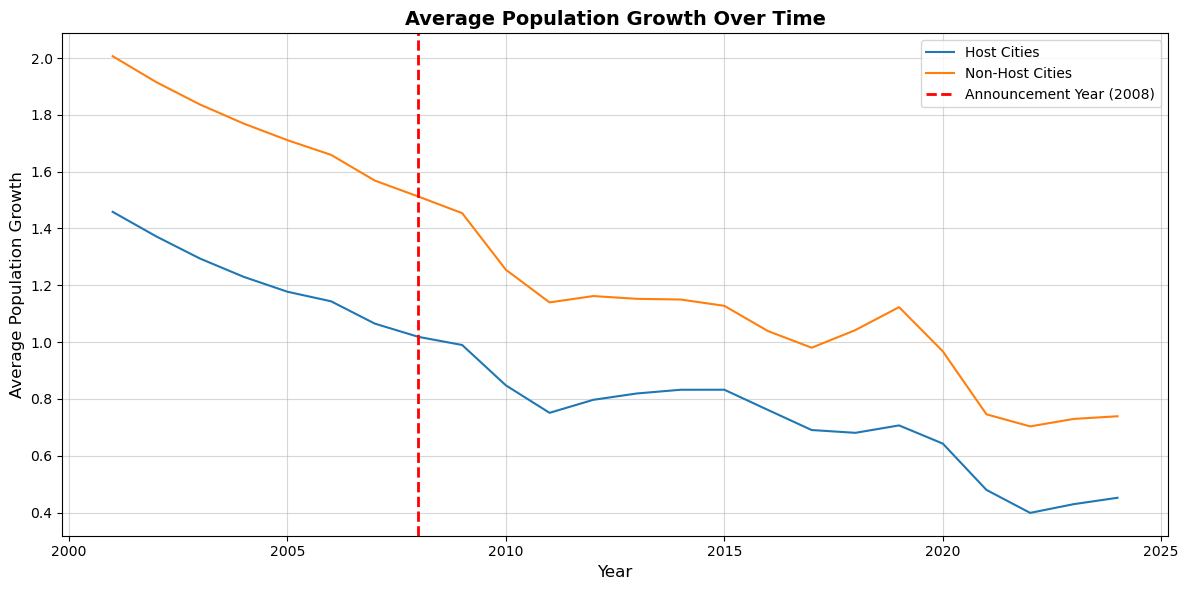

In [50]:
# Filter the data for host and non-host states
host_states_population = population_growth_long_df[population_growth_long_df['STATE'].isin(host_states)]
non_host_states_population = population_growth_long_df[population_growth_long_df['STATE'].isin(non_host_states)]

# Aggregate average population growth by year for host and non-host states
host_pop = host_states_population.groupby('YEAR')['Population_growth'].mean().reset_index()
non_host_pop = non_host_states_population.groupby('YEAR')['Population_growth'].mean().reset_index()


# Create the plot
plt.figure(figsize=(12, 6))

# Plot population growth trends for host and non-host states
plt.plot(host_pop['YEAR'], host_pop['Population_growth'],  label='Host Cities')
plt.plot(non_host_pop['YEAR'], non_host_pop['Population_growth'], label='Non-Host Cities')

# Add vertical line for the treatment year
plt.axvline(x=treatment_year, color='red', linestyle='--', linewidth=2, label='Announcement Year (2008)')

# Add title, labels, and legend
plt.title('Average Population Growth Over Time', fontsize=14, fontweight='bold')
plt.xlabel('Year', fontsize=12)
plt.ylabel('Average Population Growth', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(alpha=0.5)
plt.legend(fontsize=10)

# Show the plot
plt.tight_layout()
plt.show()

In [23]:
# Define the treatment year as a Pandas Period object with annual frequency
# This represents the year when the World Cup took place
world_cup_treatment = pd.Period("2008", freq="Y")

# Convert the 'YEAR' column in the DataFrame to a Pandas PeriodIndex with annual frequency
# Ensures that the 'YEAR' column is treated as a time-based index, useful for comparisons
population_growth_long_df['Year'] = pd.PeriodIndex(population_growth_long_df['YEAR'].astype(str), freq='Y')

# Create a new column 'post_treatment' indicating whether each year is after the treatment year
# Assigns 1 if the year is after 2014, and 0 otherwise
population_growth_long_df['post_treatment'] = (population_growth_long_df['Year'] > world_cup_treatment).astype(int)

# Create a new column 'treatment_group' to indicate whether each state is a host state
# Assigns 1 for host states and 0 for non-host states
population_growth_long_df['treatment_group'] = (population_growth_long_df['STATE'].isin(host_states)).astype(int)

population_growth_long_df.head()


,STATE,YEAR,Population_growth,Year,post_treatment,treatment_group
0,Acre,2001,3.064908,2001,0,0
1,Alagoas,2001,1.247077,2001,0,0
2,Amapá,2001,4.333029,2001,0,0
3,Amazonas,2001,2.477657,2001,0,1
4,Bahia,2001,0.901883,2001,0,1


In [24]:
formula = 'Population_growth ~ post_treatment + treatment_group + post_treatment*treatment_group'

model = smf.ols(formula, data=population_growth_long_df)
results = model.fit(cov_type='HC3')
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:      Population_growth   R-squared:                       0.234
Model:                            OLS   Adj. R-squared:                  0.230
Method:                 Least Squares   F-statistic:                     65.28
Date:                Mon, 02 Dec 2024   Prob (F-statistic):           7.26e-37
Time:                        16:12:53   Log-Likelihood:                -643.17
No. Observations:                 648   AIC:                             1294.
Df Residuals:                     644   BIC:                             1312.
Df Model:                           3                                         
Covariance Type:                  HC3                                         
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept   

### GDP DiD

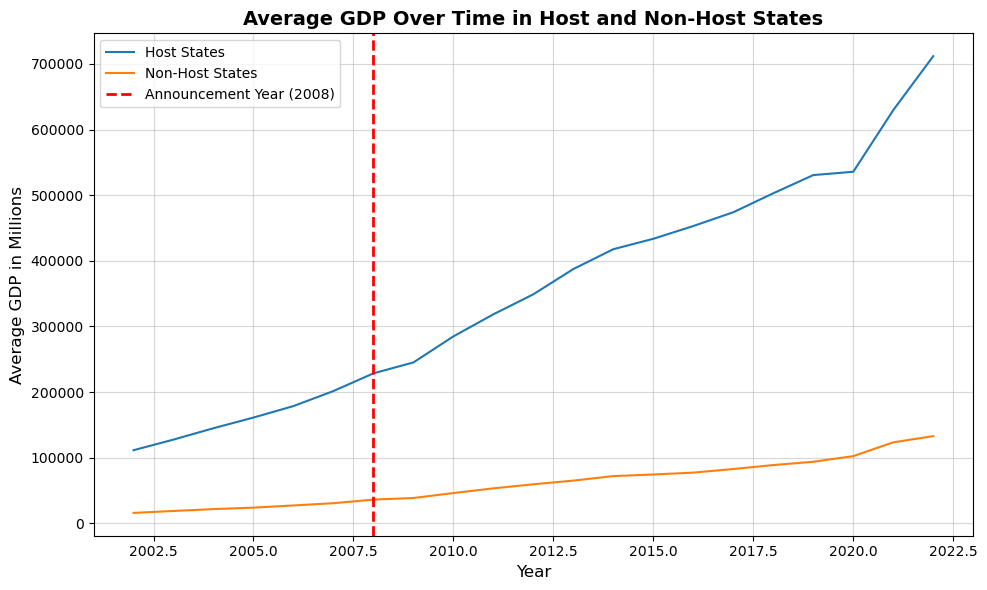

In [49]:

# Filter the data for host and non-host states
host_states_GDP = gdp_long_df[gdp_long_df['STATE'].isin(host_states)]
non_host_states_GDP = gdp_long_df[gdp_long_df['STATE'].isin(non_host_states)]

# Aggregate average GDP by year for host and non-host states
host_GDP = host_states_GDP.groupby('YEAR')['GDP'].mean().reset_index()
non_host_GDP = non_host_states_GDP.groupby('YEAR')['GDP'].mean().reset_index()

# Create a figure for side-by-side line plots
plt.figure(figsize=(10, 6))

# Plot GDP trends for host states
plt.plot(host_GDP['YEAR'], host_GDP['GDP'], label='Host States')

# Plot GDP trends for non-host states
plt.plot(non_host_GDP['YEAR'], non_host_GDP['GDP'], label='Non-Host States')

# Add vertical line for the World Cup year
plt.axvline(x=treatment_year, color='red', linestyle='--', linewidth=2, label='Announcement Year (2008)')

# Add titles and labels
plt.title('Average GDP Over Time in Host and Non-Host States', fontsize=14, fontweight='bold')
plt.xlabel('Year', fontsize=12)
plt.ylabel('Average GDP in Millions', fontsize=12)

# Add grid and legend
plt.grid(alpha=0.5)
plt.legend(fontsize=10)

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

In [27]:
# Convert the 'YEAR' column into a Pandas PeriodIndex with an annual frequency
# This ensures the 'YEAR' column is treated as time-based data, enabling proper time comparisons
gdp_long_df['Year'] = pd.PeriodIndex(gdp_long_df['YEAR'].astype(str), freq='Y')

# Create a new column 'post_treatment' to indicate whether the year is after the treatment year (2014)
# Assigns 1 if the year is after 2014 (post-treatment), and 0 otherwise
gdp_long_df['post_treatment'] = (gdp_long_df['Year'] > world_cup_treatment).astype(int)

# Create a new column 'treatment_group' to indicate whether the state is in the treatment group (host states)
# Assigns 1 for host states and 0 for non-host states
gdp_long_df['treatment_group'] = (gdp_long_df['STATE'].isin(host_states)).astype(int)

gdp_long_df.head()

,STATE,YEAR,GDP,Year,post_treatment,treatment_group
0,Rondônia,2002,7467.629889,2002,0,0
1,Acre,2002,2971.301278,2002,0,0
2,Amazonas,2002,22093.338008,2002,0,1
3,Roraima,2002,2392.032670,2002,0,0
4,Pará,2002,26482.158869,2002,0,0


In [28]:
gdpformula = 'GDP ~ post_treatment + treatment_group + post_treatment*treatment_group'

gdpmodel = smf.ols(gdpformula, data=gdp_long_df)
results = gdpmodel.fit(cov_type='HC3')
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                    GDP   R-squared:                       0.233
Model:                            OLS   Adj. R-squared:                  0.229
Method:                 Least Squares   F-statistic:                     69.92
Date:                Mon, 02 Dec 2024   Prob (F-statistic):           1.90e-38
Time:                        16:14:08   Log-Likelihood:                -7962.9
No. Observations:                 567   AIC:                         1.593e+04
Df Residuals:                     563   BIC:                         1.595e+04
Df Model:                           3                                         
Covariance Type:                  HC3                                         
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept   

### Industry level GDP DiD

In [29]:
industry_level_data.head()

,GDP,STATE,YEAR,Industry
0,284337.00,Acre,2002,Agriculture
1,355041.00,Acre,2002,Industry
2,1071069.00,Acre,2002,Services
3,4.44,Acre,2002,Electricity and Gas Supply
4,381300.00,Acre,2003,Agriculture


In [30]:
host_states_population = population_growth_long_df[population_growth_long_df['STATE'].isin(host_states)]
non_host_states_population = population_growth_long_df[population_growth_long_df['STATE'].isin(non_host_states)]

# Aggregate average population growth by year for host and non-host states
host_pop = host_states_population.groupby('YEAR')['Population_growth'].mean().reset_index()
non_host_pop = non_host_states_population.groupby('YEAR')['Population_growth'].mean().reset_index()


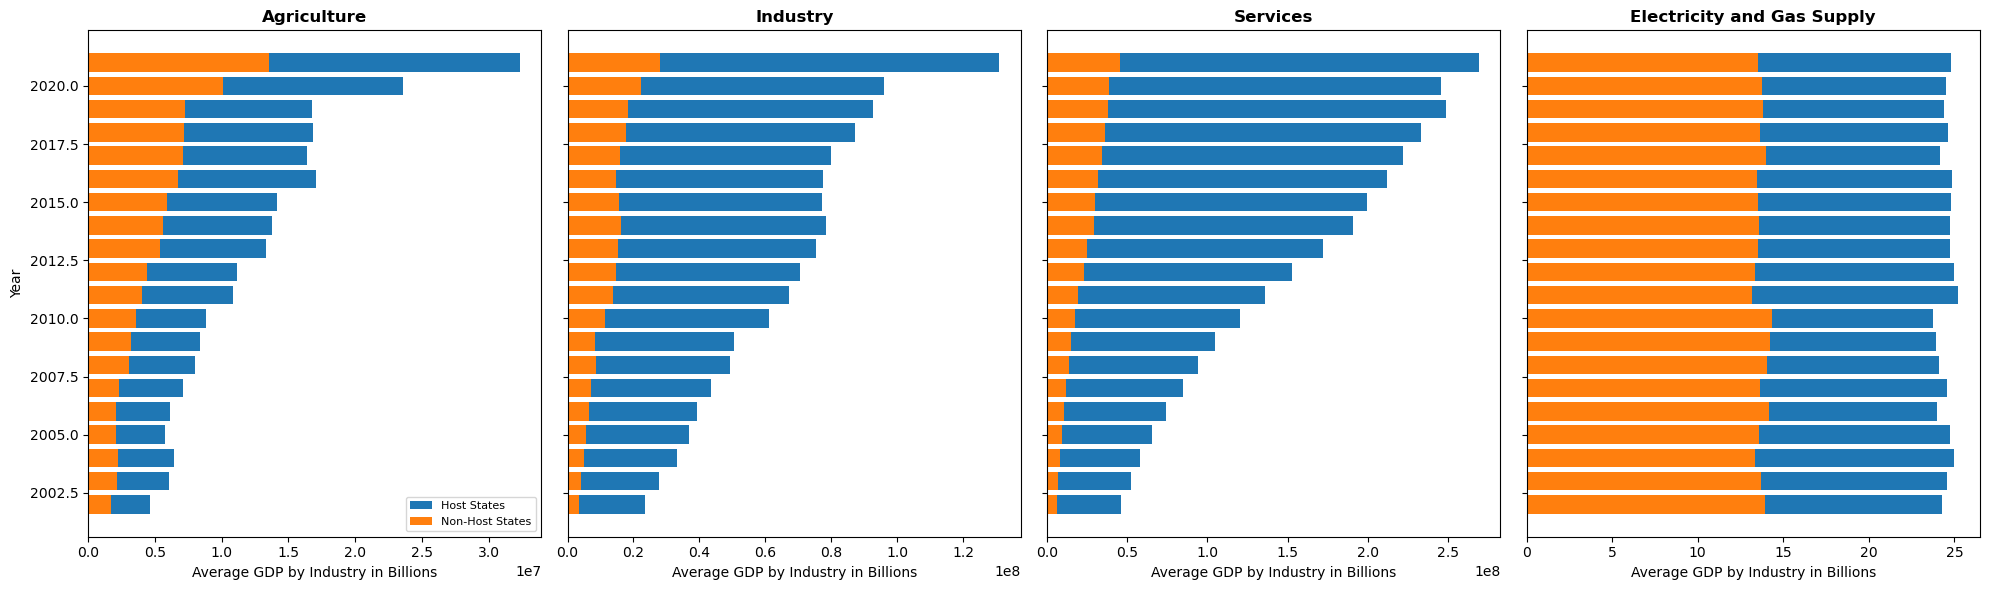

In [37]:
# List of industry-specific DataFrames
industries_df = [agrigulture_df, industry_df, services_df, electricity_gas_df]

# Get a list of unique industries
industries = industry_level_data['Industry'].unique()

# Set up subplots in a single row
fig, axes = plt.subplots(1, len(industries_df), figsize=(20, 6), sharey=True)

for idx, (industry, df) in enumerate(zip(industries, industries_df)):

    # print (industry)
    # display(industry_df)
    # Filter data for host and non-host states
    host = df[df['STATE'].isin(host_states)]
    non_host = df[df['STATE'].isin(non_host_states)]

    # Aggregate GDP by year for host and non-host states
    host_gdp = host.groupby('YEAR')['GDP'].mean().reset_index()
    non_host_gdp = non_host.groupby('YEAR')['GDP'].mean().reset_index()

    # Plot for the current industry

    
    ax = axes[idx]
    ax.barh(host_gdp['YEAR'], host_gdp['GDP'], label='Host States')
    ax.barh(non_host_gdp['YEAR'], non_host_gdp['GDP'], label='Non-Host States')

    # Add titles and labels for each subplot
    ax.set_title(f'{industry}', fontsize=12, fontweight='bold')
    ax.set_xlabel('Average GDP by Industry in Billions')
    if idx == 0:  # Only the first plot needs a y-axis label and legend
        ax.set_ylabel('Year')
        ax.legend(fontsize=8)
    else:
        ax.legend().remove()  # Remove legend for other plots

# Adjust layout to ensure proper spacing
plt.tight_layout()

# Show the plot
plt.show()


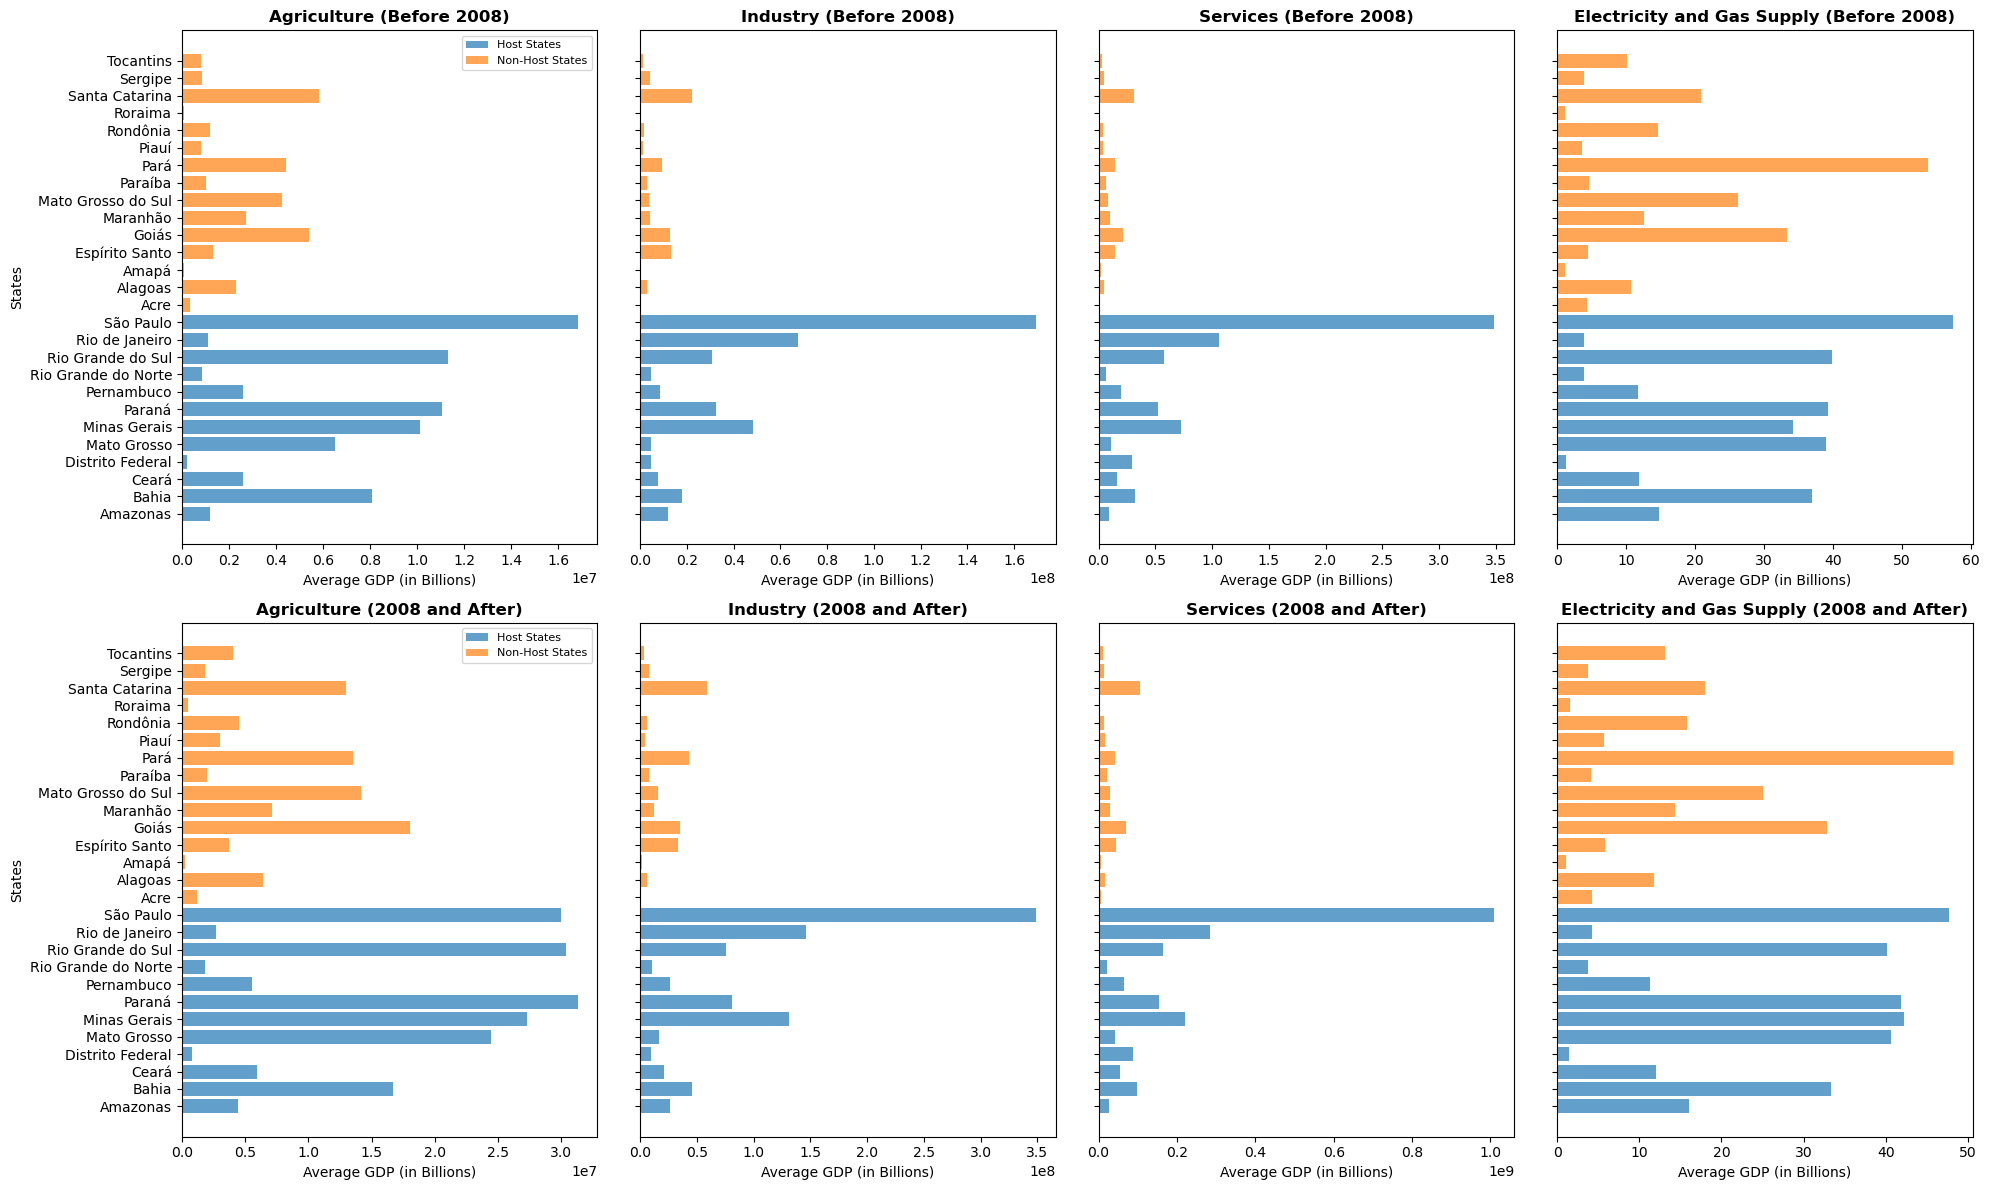

In [36]:
# Define the cutoff year for the Olympics announcement
announcement_year = 2008

# Set up subplots for before and after the Olympics announcement
fig, axes = plt.subplots(2, len(industries_df), figsize=(20, 12), sharey=True)

for idx, (industry, df) in enumerate(zip(industries, industries_df)):
    # Filter data for host and non-host states before and after the Olympics announcement
    before_host = df[(df['STATE'].isin(host_states)) & (df['YEAR'] < announcement_year)]
    before_non_host = df[(df['STATE'].isin(non_host_states)) & (df['YEAR'] < announcement_year)]
    after_host = df[(df['STATE'].isin(host_states)) & (df['YEAR'] >= announcement_year)]
    after_non_host = df[(df['STATE'].isin(non_host_states)) & (df['YEAR'] >= announcement_year)]

    # Aggregate GDP for before and after the Olympics announcement
    before_host_gdp = before_host.groupby('STATE')['GDP'].mean().reset_index()
    before_non_host_gdp = before_non_host.groupby('STATE')['GDP'].mean().reset_index()
    after_host_gdp = after_host.groupby('STATE')['GDP'].mean().reset_index()
    after_non_host_gdp = after_non_host.groupby('STATE')['GDP'].mean().reset_index()

    # Combine data for plotting
    before_combined_gdp = pd.concat([
        before_host_gdp.assign(Group='Host States'),
        before_non_host_gdp.assign(Group='Non-Host States')
    ])
    after_combined_gdp = pd.concat([
        after_host_gdp.assign(Group='Host States'),
        after_non_host_gdp.assign(Group='Non-Host States')
    ])

    # Plot before Olympics announcement
    ax_before = axes[0, idx]
    for group, data in before_combined_gdp.groupby('Group'):
        ax_before.barh(data['STATE'], data['GDP'], label=group if idx == 0 else "", alpha=0.7)
    ax_before.set_title(f'{industry} (Before 2008)', fontsize=12, fontweight='bold')
    ax_before.set_xlabel('Average GDP (in Billions)')
    if idx == 0:
        ax_before.set_ylabel('States')
        ax_before.legend(fontsize=8)

    # Plot after Olympics announcement
    ax_after = axes[1, idx]
    for group, data in after_combined_gdp.groupby('Group'):
        ax_after.barh(data['STATE'], data['GDP'], label=group if idx == 0 else "", alpha=0.7)
    ax_after.set_title(f'{industry} (2008 and After)', fontsize=12, fontweight='bold')
    ax_after.set_xlabel('Average GDP (in Billions)')
    if idx == 0:
        ax_after.set_ylabel('States')
        ax_after.legend(fontsize=8)

# Adjust layout to ensure proper spacing
plt.tight_layout()

# Show the plot
plt.show()



In [39]:
industries = [agrigulture_df, industry_df, services_df, electricity_gas_df]

models = []

for industry_data in industries:
    # Add a 'Year' column as a PeriodIndex for time-series analysis
    industry_data['Year'] = pd.PeriodIndex(industry_data['YEAR'].astype(str), freq='Y')

    # Create a 'post_treatment' variable indicating whether the observation is after the World Cup
    industry_data['post_treatment'] = (industry_data['Year'] > world_cup_treatment).astype(int)

    # Create a 'treatment_group' variable indicating whether the observation is in a host state
    industry_data['treatment_group'] = (industry_data['STATE'].isin(host_states)).astype(int)

    # Define the formula for the Difference-in-Differences model
    formula = 'GDP ~ post_treatment + treatment_group + post_treatment:treatment_group'

    # Fit an Ordinary Least Squares (OLS) regression model using statsmodels
    model = smf.ols(formula, data=industry_data).fit(cov_type='HC3')

    # Store the model and the corresponding industry name in the models list
    models.append({
        "industry": industry_data['Industry'].iloc[0],  # Get the industry name
        "model": model  # Store the fitted model
    })

# Display summary for each model
for item in models:
    print(f"Industry: {item['industry']}")
    print(item['model'].summary())

Industry: Agriculture
                            OLS Regression Results                            
Dep. Variable:                    GDP   R-squared:                       0.213
Model:                            OLS   Adj. R-squared:                  0.208
Method:                 Least Squares   F-statistic:                     63.62
Date:                Mon, 02 Dec 2024   Prob (F-statistic):           3.37e-35
Time:                        16:27:28   Log-Likelihood:                -9444.6
No. Observations:                 540   AIC:                         1.890e+04
Df Residuals:                     536   BIC:                         1.891e+04
Df Model:                           3                                         
Covariance Type:                  HC3                                         
                                     coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------

/var/folders/gr/mhlc8kfs39b7v4v54d1fd4bc0000gn/T/ipykernel_62720/3399734054.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  industry_data['Year'] = pd.PeriodIndex(industry_data['YEAR'].astype(str), freq='Y')
/var/folders/gr/mhlc8kfs39b7v4v54d1fd4bc0000gn/T/ipykernel_62720/3399734054.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  industry_data['post_treatment'] = (industry_data['Year'] > world_cup_treatment).astype(int)
/var/folders/gr/mhlc8kfs39b7v4v54d1fd4bc0000gn/T/ipykernel_62720/3399734054.py:

### Uneployment DiD

In [62]:
unemplyment_df.head()

,STATE,YEAR,unemployment_rate,Year,post_treatment,treatment_group
0,Acre,2012,329.8,2012,0,0
1,Acre,2013,331.9,2013,0,0
2,Acre,2014,305.2,2014,0,0
3,Acre,2015,318.9,2015,1,0
4,Acre,2016,346.0,2016,1,0


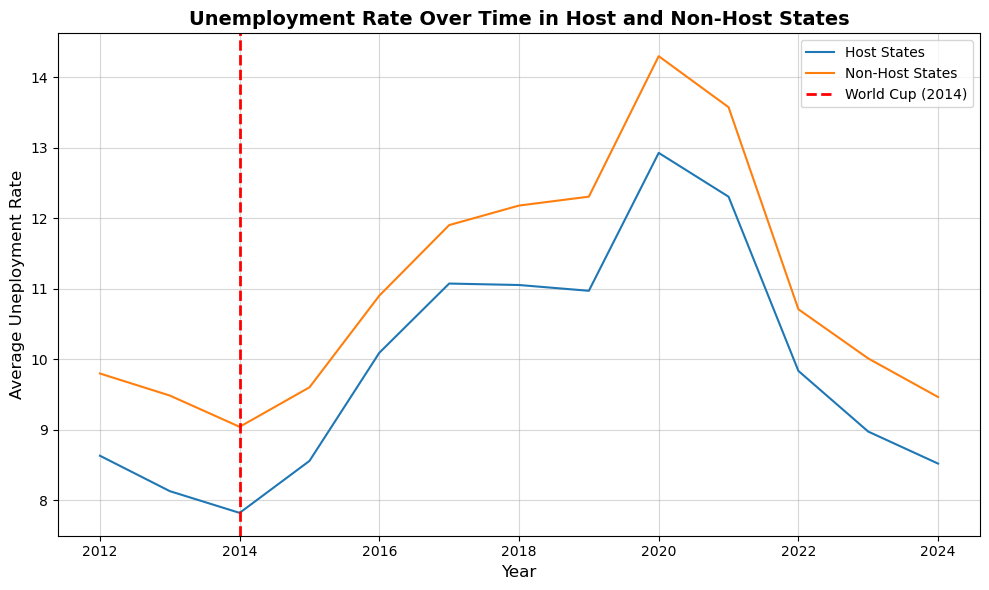

In [47]:
# Filter the data for host and non-host states
host_states_uneployment = unemplyment_df[unemplyment_df['STATE'].isin(host_states)]
non_host_states_uneployment = unemplyment_df[unemplyment_df['STATE'].isin(non_host_states)]

host_uneployment = host_states_uneployment.groupby('YEAR')['unemployment_rate'].mean().reset_index()
non_host_uneployment = non_host_states_uneployment.groupby('YEAR')['unemployment_rate'].mean().reset_index()

# Define the year of the World Cup treatment
treatment_year = 2014

# Create the plot
plt.figure(figsize=(10, 6))

# Plot unemployment for host states
plt.plot(host_uneployment['YEAR'], host_uneployment['unemployment_rate'], label='Host States')

# Plot unemployment trends for non-host states
plt.plot(non_host_uneployment['YEAR'], non_host_uneployment['unemployment_rate'], label='Non-Host States')

# Add vertical line for the World Cup year
plt.axvline(x=treatment_year, color='red', linestyle='--', linewidth=2, label='World Cup (2014)')

# Add titles and labels
plt.title('Unemployment Rate Over Time in Host and Non-Host States', fontsize=14, fontweight='bold')
plt.xlabel('Year', fontsize=12)
plt.ylabel('Average Uneployment Rate', fontsize=12)

# Add grid and legend
plt.grid(alpha=0.5)
plt.legend(fontsize=10)

# Adjust layout and show the plot
plt.tight_layout()
plt.show()




In [42]:
world_cup_treatment = pd.Period("2014", freq="Y")

unemplyment_df['Year'] = pd.PeriodIndex(unemplyment_df['YEAR'].astype(str), freq='Y')

    # Create a 'post_treatment' variable indicating whether the observation is after the World Cup
unemplyment_df['post_treatment'] = (unemplyment_df['Year'] > world_cup_treatment).astype(int)

    # Create a 'treatment_group' variable indicating whether the observation is in a host state
unemplyment_df['treatment_group'] = (unemplyment_df['STATE'].isin(host_states)).astype(int)

    # Define the formula for the Difference-in-Differences model
formula = 'unemployment_rate ~ post_treatment + treatment_group + post_treatment:treatment_group'

    # Fit an Ordinary Least Squares (OLS) regression model using statsmodels
model = smf.ols(formula, data=unemplyment_df).fit(cov_type='HC3')

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:      unemployment_rate   R-squared:                       0.120
Model:                            OLS   Adj. R-squared:                  0.112
Method:                 Least Squares   F-statistic:                     20.84
Date:                Mon, 02 Dec 2024   Prob (F-statistic):           1.94e-12
Time:                        16:34:07   Log-Likelihood:                -867.04
No. Observations:                 351   AIC:                             1742.
Df Residuals:                     347   BIC:                             1758.
Df Model:                           3                                         
Covariance Type:                  HC3                                         
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept   

### Carbon Emissions DiD

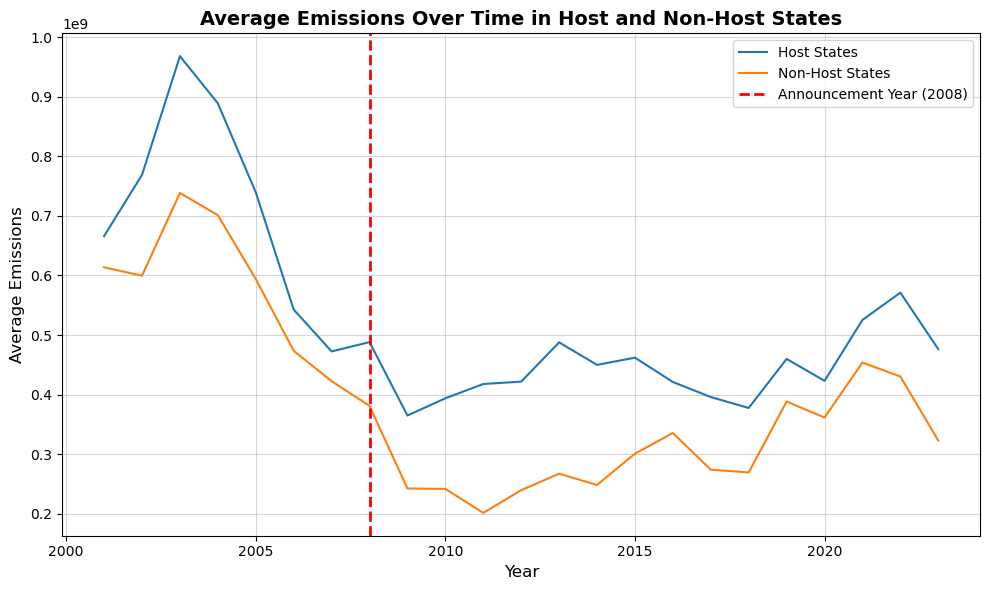

In [48]:
# Filter the data for host and non-host states
host_states_emissions = emissions_long_df[emissions_long_df['STATE'].isin(host_states)]
non_host_states_emissions = emissions_long_df[emissions_long_df['STATE'].isin(non_host_states)]

# Aggregate average emissions by year for host and non-host states
host_emissions = host_states_emissions.groupby('YEAR')['EMISSIONS'].mean().reset_index()
non_host_emissions = non_host_states_emissions.groupby('YEAR')['EMISSIONS'].mean().reset_index()

# Define the year of the World Cup treatment
treatment_year = 2008

# Create the plot
plt.figure(figsize=(10, 6))

# Plot emissions trends for host states
plt.plot(host_emissions['YEAR'], host_emissions['EMISSIONS'], label='Host States')

# Plot emissions trends for non-host states
plt.plot(non_host_emissions['YEAR'], non_host_emissions['EMISSIONS'], label='Non-Host States')

# Add vertical line for the World Cup year
plt.axvline(x=treatment_year, color='red', linestyle='--', linewidth=2, label='Announcement Year (2008)')

# Add titles and labels
plt.title('Average Emissions Over Time in Host and Non-Host States', fontsize=14, fontweight='bold')
plt.xlabel('Year', fontsize=12)
plt.ylabel('Average Emissions', fontsize=12)

# Add grid and legend
plt.grid(alpha=0.5)
plt.legend(fontsize=10)

# Adjust layout and show the plot
plt.tight_layout()
plt.show()



In [31]:
emissions_long_df.head()

,STATE,YEAR,EMISSIONS
0,Acre,2001,1.903451e+08
1,Alagoas,2001,4.801885e+07
2,Amapá,2001,-3.509315e+07
3,Amazonas,2001,-5.323357e+08
4,Bahia,2001,5.672076e+08


In [46]:
emissions_long_df['Year'] = pd.PeriodIndex(emissions_long_df['YEAR'].astype(str), freq='Y')

    # Create a 'post_treatment' variable indicating whether the observation is after the World Cup
emissions_long_df['post_treatment'] = (emissions_long_df['Year'] > world_cup_treatment).astype(int)

    # Create a 'treatment_group' variable indicating whether the observation is in a host state
emissions_long_df['treatment_group'] = (emissions_long_df['STATE'].isin(host_states)).astype(int)

    # Define the formula for the Difference-in-Differences model
formula = 'EMISSIONS ~ post_treatment + treatment_group + post_treatment:treatment_group'

    # Fit an Ordinary Least Squares (OLS) regression model using statsmodels
model = smf.ols(formula, data=emissions_long_df).fit(cov_type='HC3')

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:              EMISSIONS   R-squared:                       0.009
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     1.951
Date:                Mon, 02 Dec 2024   Prob (F-statistic):              0.120
Time:                        16:39:13   Log-Likelihood:                -14076.
No. Observations:                 644   AIC:                         2.816e+04
Df Residuals:                     640   BIC:                         2.818e+04
Df Model:                           3                                         
Covariance Type:                  HC3                                         
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept   

# Final Conclusion: Impact of the 2014 World Cup on Host States

### Overall Summary
The analysis reveals that hosting the 2014 World Cup had clear economic benefits for the host states, particularly in terms of GDP growth and resilience to unemployment. However, these benefits were concentrated in more developed and urbanized regions, potentially exacerbating existing regional inequalities. The event also demonstrated that large-scale sports events can be managed sustainably without significantly impacting emissions, which is crucial for planning future international events. 

## 1. Economic Growth and Industrial Development
The Difference-in-Differences (DiD) regression results, along with the graphical analysis, clearly show that the host states experienced accelerated economic growth compared to non-host states after the World Cup announcement in 2008.

- **GDP Findings**: Host states already had a higher baseline GDP than non-host states before 2008, reflecting their existing economic strength. Post-2008, the GDP in host states grew at a much faster rate, with the service sector being the primary beneficiary.

- **Sectoral Insights**: The service sector saw the largest gains. The industrial sector also benefited significantly, driven by infrastructure construction and related activities during the preparation phase.

## 2. Population and Demographic Dynamics
The population growth analysis reveals that host states had consistently lower growth rates than non-host states, both before and after the World Cup. This suggests that the selected host regions were likely already more developed and urbanized, which resulted in lower natural population growth rates compared to more rural, less developed areas.

- **Minimal Impact on Population Growth**: There was no observable surge in population growth in host states after the World Cup announcement or during the event itself. This suggests that while hosting the event might have led to a temporary influx of people (e.g., workers or tourists), it did not lead to long-term demographic changes or a significant migration effect.

## 3. Employment Effects
The unemployment analysis indicates that host states had lower baseline unemployment rates compared to non-host states, showcasing their stronger labor markets. During the World Cup year (2014), both host and non-host states experienced a dip in unemployment, likely due to temporary job creation related to event activities.

- **Post-Event Resilience**: Post-2014, host states showed greater resilience in terms of unemployment rates compared to non-host states. While unemployment rose in both groups, the increase was much steeper in non-host states, indicating that the economic boost from hosting helped buffer host states against broader economic downturns.

## 4. Environmental Impact
The emissions analysis shows that host states had consistently higher emissions compared to non-host states, primarily due to their urban and industrial nature. However, the World Cup itself did not create a significant or lasting spike in emissions.

## 5. Broader Implications
- **Economic Concentration**: The economic benefits of hosting the World Cup were concentrated in a few already-developed states, highlighting the potential for such events to widen regional disparities. 

- **Sectoral Gains and Long-Term Benefits**: Hosting the World Cup had the most pronounced effects on the service sector, with significant growth in tourism, hospitality, and entertainment. These gains appear to have had a lasting impact on the host states, enhancing their economic resilience. Future event-hosting strategies should focus on maximizing these long-term sectoral benefits, particularly in sectors that directly benefit from tourism and international exposure.

- **Environmental Considerations**: The findings also demonstrate that it is possible to host mega-events without significantly increasing emissions. This points to the effectiveness of sustainable event practices and highlights the importance of integrating environmental planning into large-scale event preparation.

